In [1]:
import sys
sys.path.append('../../../')

#### Local Plotting Tools ####
from plot_tools.fig_preamble import *
from plot_tools.plot_helper_funcs import cm2inch

#### Matplotlib & Numpy ####
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from data_tools.load_raw_cluster_data import LoadExperiment
from data_tools.data_risk_analysis import analyse_kalman_errs
from qif.common import inverse_Ricatti_recursion, inverse_Ricatti_recursion_coinflip
from qif.common import generate_AR, noisy_z, projected_msmt, qkf_state_err, normalise
from akf.armakf import get_autoreg_model
from qif.qif import qif as qif

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


In [2]:
ver=0
test_case=24
variation_scan=[1, 2, 3, 4]
datapath2 = '../../DATA_v'+str(ver)+'_/'#



In [3]:
runs = 100
true_rk_quant = 0.001**2
p0init = 10000 

######## True Process Noise Strength
true_oe = 0.1
######## True Msmt Noise Strength
true_rk = 0.1**2
####

mean_noise = 0.5*np.pi
burn_in = 500

ensemble_x = np.zeros((len(variation_scan), runs,  2050))
ensemble_z = np.zeros((len(variation_scan), runs, 2050))
ensemble_crlb = np.zeros((len(variation_scan), runs, 2050))
ensemble_err = np.zeros((len(variation_scan), runs, 2050))
ensemble_crlb_coinflip = np.zeros((len(variation_scan), runs, 2050))

for idx_var in xrange(len(variation_scan)):
    
    experiment = 0
    experiment = LoadExperiment(test_case, variation_scan[idx_var], 
                                QKF_load='Yes',
                                QKF_path=datapath2,
                                LKFFB_load ='Yes',
                                LKFFB_path=datapath2,
                                LSF_load='No',
                                AKF_load='Yes', 
                                AKF_path=datapath2,
                                GPRP_load='No')

    shape = experiment.AKF_macro_truth.shape
    # truth_bank = experiment.AKF_macro_truth.reshape(shape[0]*shape[1], shape[2])

    indices, srtd_risk, srtd_sigma, srtd_R = analyse_kalman_errs(experiment.QKF_macro_prediction_errors,
                                                                 experiment.QKF_random_hyperparams_list,
                                                                 50)
    order = experiment.AKF_weights.shape[0]
    dynamical_model = get_autoreg_model(order, experiment.AKF_weights)

    for idx_runs in xrange(runs):
        
        # true_x = truth_bank[idx_runs, :] + mean_noise 
        
        x_init = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=order)
        true_x = generate_AR(x_init, 2050 + burn_in, experiment.AKF_weights, true_oe)[burn_in:] + mean_noise 
        
        # f_n_dataset = true_x + experiment.AKF_msmt_noise_variance*np.random.standard_normal(true_x.shape)
        
        f_n_dataset = true_x + true_rk*np.random.standard_normal(true_x.shape)
        noisy_z_ = noisy_z( f_n_dataset, true_rk_quant) # z is mean zero
        y_signal = projected_msmt(noisy_z_)

        predictions, W, x_hat, P_hat, err_true_dynamics = qif('AKFdynamics', y_signal, 
                                                                          experiment.AKF_weights, 
                                                                          true_oe, 
                                                                          true_rk,
                                                                          n_train=2000, 
                                                                          n_testbefore=50, 
                                                                          n_predict=50, 
                                                                          p0=p0init, skip_msmts=1,  save='No')
        ensemble_x[idx_var, idx_runs, :] = x_hat[0,0,:]
        ensemble_z[idx_var, idx_runs, :] = noisy_z(x_hat[0,0,:], 0.0)
        ensemble_err[idx_var, idx_runs, :] = err_true_dynamics

        ensemble_crlb[idx_var, idx_runs, :] = inverse_Ricatti_recursion(true_x, 
                                              noisy_z(true_x, 0.0), 
                                              true_oe, true_rk, 
                                              dynamical_model, time_steps=2050, p0=1./p0init)
        
        ensemble_crlb_coinflip[idx_var, idx_runs, :] = inverse_Ricatti_recursion_coinflip(true_x, 
                                              noisy_z(true_x, 0.0), 
                                              true_oe, true_rk, 
                                              dynamical_model, time_steps=2050, p0=1./p0init)

AKF: Data Loaded? Yes
LKFFB: Data Loaded? Yes
QKF: Data Loaded? Yes
AKF: Data Loaded? Yes
LKFFB: Data Loaded? Yes
QKF: Data Loaded? Yes
AKF: Data Loaded? Yes
LKFFB: Data Loaded? Yes
QKF: Data Loaded? Yes
AKF: Data Loaded? Yes
LKFFB: Data Loaded? Yes
QKF: Data Loaded? Yes


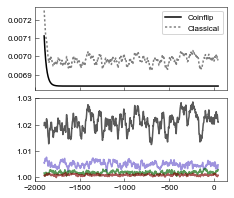

In [64]:
COLOR = ['k', 'slateblue', 'darkgreen', 'maroon']
LABELS = ['0.2', '0.4', '0.6', '0.8']

gs = gridspec.GridSpec(2,1,
                       left=0.2, right=0.985, 
                       top=0.92, bottom=0.15, 
                       wspace=0.03, hspace=0.1)

fig = plt.figure(figsize=(cm2inch(8.6),cm2inch(8.)))

ax_0 = fig.add_subplot(gs[1, 0])
ax_1 = fig.add_subplot(gs[0, 0])
# ax_1 = fig.add_axes([0.72, 0.22, 0.11, 0.09]) 


for idx_var in xrange(len(variation_scan)):

    ax_0.plot(range(-1900, 50), np.mean(ensemble_crlb_coinflip, axis=1)[idx_var, 100::1]/np.mean(ensemble_crlb, axis=1)[idx_var, 100::1], 
             '-', c=COLOR[idx_var], alpha=0.65, label=LABELS[idx_var])
    
ax_1.plot(range(-1900, 50), 1./np.mean(ensemble_crlb_coinflip, axis=1)[0, 100::1], '-', 
           c=COLOR[0], alpha=1.0, label='Coinflip')
ax_1.plot(range(-1900, 50), 1./np.mean(ensemble_crlb, axis=1)[0, 100::1], ':', 
            c=COLOR[0], alpha=0.5, label='Classical')


for ax in [ax_0, ax_1]:
    ax.set_yscale('linear')
    ax.set_xscale('linear')
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))   
    ax.tick_params(direction='in', which='both')
    ax = set_font_sizes(ax, fsize, Fsize)
#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=2))
#     ax.set_ylim([0.1, 10])
#     ax.set_xlim([0.5, 50])

ax_1.set(xticklabels='')
ax_1.minorticks_off()
ax_1.legend(loc=0)

plt.savefig('CRLB.svg', dpi=my_dpi)
plt.show()

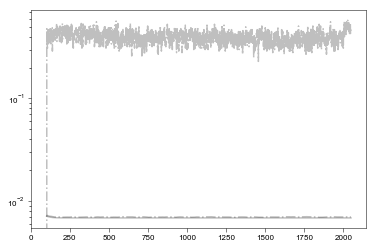

In [69]:
COLOR = ['k', 'slateblue', 'darkgreen', 'maroon']
LABELS = ['0.2', '0.4', '0.6', '0.8']

plt.figure()
for idx_var in xrange(1):
    
# Residuals
#     plt.plot(np.mean(ensemble_err**2, axis=1)[idx_var, 100::1], '--', 
#              c=COLOR[idx_var], alpha=0.5, label=idx_var)

# Residuals * Fisher Info
    # normalise error trains by multiplying with P^-1 from information filtering recursion.
    # absolute trajectories for CRLB or error trains don't make sense across cases due to the scaling differences
    # in how noise traces are generated for different spectral components


    plt.plot(range(100, 2050), np.mean(ensemble_err**2, axis=1)[idx_var, 100::1], '-.', 
             c=COLOR[idx_var], alpha=0.25, label=idx_var)


    plt.plot(range(100, 2050), 1./np.mean(ensemble_crlb, axis=1)[idx_var, 100::1], '-.', 
               c=COLOR[idx_var], alpha=0.25, label='CRLB - Classical Quantisation')
    
#     plt.plot(range(100, 2050), 1./np.mean(ensemble_crlb_coinflip, axis=1)[idx_var, 100::1], '-', 
#            c=COLOR[idx_var], alpha=0.25, label=idx_var)
    
    
#     plt.plot(range(-1900, 50), np.mean(ensemble_crlb_coinflip, axis=1)[idx_var, 100::1]/np.mean(ensemble_crlb, axis=1)[idx_var, 100::1], 
#              '-', 
#             c=COLOR[idx_var], alpha=0.25, label=LABELS[idx_var])
    
    plt.plot(range(100, 2050), 1./np.mean(ensemble_crlb_coinflip, axis=1)[idx_var, 100::1], '-', 
           c=COLOR[idx_var], alpha=0.25, label=idx_var)
    
#     plt.ylim([0.001, 1. ])
    plt.yscale('log')
    # plt.xscale('log')
#     plt.legend(loc=5)
    
#plt.savefig('CRLB.svg', dpi=my_dpi)
plt.show()

In [5]:
pwd

u'/home/riddhisw/Documents/2017/Scripts_Git/v0/TEST_SCRIPTS_v0/QIF'